# Floaty MLP
#### Alessandro Di Giorgio, MPI-IS Tübingen, 15/10/25

## Import the acquired data and define an evaluation function for testing
Obtained by means of several runs on different input trajectories

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

def load_floaty_full_data(file_path):
    """
    Loads the Floaty dataset from a .csv file and returns:
    - All relevant data concatenated in columns (excluding accelerations)
    - Individual arrays for reference
    """

    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")

    # Extract data by column name patterns
    lin_pos = df[[col for col in df.columns if col.startswith("lin_pos_")]].to_numpy()
    lin_vel = df[[col for col in df.columns if col.startswith("lin_vel_")]].to_numpy()
    lin_acc = df[[col for col in df.columns if col.startswith("lin_acc_")]].to_numpy()
    angles  = df[[col for col in df.columns if col.startswith("angle_")]].to_numpy()
    ang_rate = df[[col for col in df.columns if col.startswith("ang_rate_")]].to_numpy()
    ang_acc = df[[col for col in df.columns if col.startswith("ang_acc_")]].to_numpy()
    U = df[[col for col in df.columns if col.startswith("U_")]].to_numpy()

    # Concatenate only the desired columns (exclude accelerations)
    concatenated = np.concatenate([lin_pos, lin_vel, angles, ang_rate], axis=1)

    print(f"Concatenated data shape (without accelerations): {concatenated.shape}")

    return lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, concatenated


# Example usage
file_path = 'estimated_data2.csv'
experiment_params = {}
experiment_params['data_file'] = file_path # in case more datasets are loaded and merged, I will insert manually a string
lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, X = load_floaty_full_data(file_path)

# Compute ΔX[t] = X[t+1] - X[t]
Y = X[1:] - X[:-1]
X = X[:-1]
U = U[:-1]
# Training input
Z = np.concatenate([X,U], axis=1)

print(f"Training inputs shape: {Z.shape}, targets shape: {Y.shape}")


def test_keras_model_grouped(model_path, X_test, Y_test, sc_out, plot_dim=12):
    """
    Tests a trained Keras model on the test dataset.
    Shows detailed metrics grouped by 3-column physical groups and separate plots for each output.
    """

    # --- Load model ---
    model = load_model(model_path)
    print(f"Loaded model from: {model_path}")

    #model = model

    # --- Predict ---
    Y_pred = model.predict(X_test, verbose=0)

    # --- Denormalize predictions and ground truth ---
    Y_pred_phys = sc_out.inverse_transform(Y_pred)
    Y_true_phys = sc_out.inverse_transform(Y_test)

    # --- Compute overall metrics ---
    mse = mean_squared_error(Y_true_phys, Y_pred_phys)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_true_phys, Y_pred_phys)
    r2 = r2_score(Y_true_phys, Y_pred_phys)
    print("\n--- Overall Test Metrics ---")
    print(pd.DataFrame([{"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}]))

    # --- Define variable and group names ---
    var_names = ["Δx", "Δy", "Δz",
                 "Δvx", "Δvy", "Δvz",
                 "Δroll", "Δpitch", "Δyaw",
                 "Δp", "Δq", "Δr"]

    group_names = ["Linear Position", "Linear Velocity", "Angles", "Angular Rates"]

    # --- Compute metrics per group ---
    group_metrics = []
    for g in range(4):
        start, end = g * 3, (g + 1) * 3
        Yt_g = Y_true_phys[:, start:end]
        Yp_g = Y_pred_phys[:, start:end]
        mse_g = mean_squared_error(Yt_g, Yp_g)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(Yt_g, Yp_g)
        r2_g = r2_score(Yt_g, Yp_g)
        group_metrics.append([group_names[g], mse_g, rmse_g, mae_g, r2_g])

    df_groups = pd.DataFrame(group_metrics, columns=["Group", "MSE", "RMSE", "MAE", "R2"])

    print("\n--- Metrics by Group ---")
    print(df_groups.to_string(index=False, justify="center", float_format=lambda x: f"{x:10.6f}"))

    # --- Plot each output dimension separately ---
    n_plots = min(plot_dim, Y_true_phys.shape[1])
    for i in range(n_plots):
        plt.figure(figsize=(10, 4))
        plt.plot(Y_true_phys[:200, i], label='True', linewidth=2)
        plt.plot(Y_pred_phys[:200, i], label='Pred', linestyle='--')
        plt.title(f"{var_names[i]} ({group_names[i//3]})")
        plt.xlabel("Sample index")
        plt.ylabel(var_names[i])
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"overall": {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2},
            "groups": df_groups}

Loaded dataset with shape: (14900, 22)
Concatenated data shape (without accelerations): (14900, 12)
Training inputs shape: (14899, 16), targets shape: (14899, 12)


## Dataset shuffling, normalization and splitting

In [ ]:
def prepare_dataset( # here test set gets shuffled anyway... all sets are shuffled
    X_all, U_all, Y_all, val_ratio=0.1, test_ratio=0.1, random_seed=None
):
    """
    - Split dataset into train/val/test (randomized indices)
    - Fit scalers ONLY on TRAINING data ([X,U] and Y)
    - Apply those scalers to val/test
    - Shuffle TRAIN only in order to make the net more general (not having it learning only sequences)
    - TEST kept in random order
    ---> All focus is on predicting next deltaX with the highest accurcacy possible, not caring about rollout
    """

    # ----- Concatenate inputs -----
    X_in = np.hstack([X_all, U_all])   # shape (N, n_x + n_u)
    Y_out = Y_all                      # shape (N, n_y)
    N = len(X_in)

    # ----- Random split via indices -----
    rng = np.random.default_rng(random_seed)
    perm_all = rng.permutation(N)

    n_test = int(test_ratio * N)
    n_val  = int(val_ratio  * N)
    n_train = N - n_val - n_test
    if n_train <= 0:
        raise ValueError("Not enough samples for training. Reduce val_ratio/test_ratio.")

    idx_train = perm_all[:n_train]
    idx_val   = perm_all[n_train:n_train + n_val]
    idx_test  = perm_all[n_train + n_val:]

    # ----- Fit scalers ONLY on TRAIN subset -----
    sc_in  = StandardScaler().fit(X_in[idx_train])
    sc_out = StandardScaler().fit(Y_out[idx_train])

    # ----- Transform all splits -----
    X_train, Y_train = sc_in.transform(X_in[idx_train]), sc_out.transform(Y_out[idx_train])
    X_val,   Y_val   = sc_in.transform(X_in[idx_val]),   sc_out.transform(Y_out[idx_val])
    X_test,  Y_test  = sc_in.transform(X_in[idx_test]),  sc_out.transform(Y_out[idx_test])

    # ----- Shuffle ONLY train -----
    perm_train = rng.permutation(len(X_train))
    X_train, Y_train = X_train[perm_train], Y_train[perm_train]

    # ----- Ordered TEST view (by original time index) -----
    #  IN THIS CASE IT IS USELESS SINCE EVERYTHING IS ALREADY SHUFFLED AND ORDERING RANDOM INDICES MAKES NO SENSE,
    #  KEPT THIS JUST TO HAVE SAME FUNCTIONS IN ALL FILES
    idx_test_sorted = np.sort(idx_test)
    X_test_ordered = sc_in.transform(X_in[idx_test_sorted])
    Y_test_ordered = sc_out.transform(Y_out[idx_test_sorted])

    # ----- Info -----
    print("Scalers fit on TRAIN subset only (no data leakage).")
    print("Split: random; shuffled TRAIN & VAL only; TEST kept as-is (random), plus ordered view returned.")
    print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    return (
        X_train, Y_train,
        X_val, Y_val,
        X_test, Y_test,               # random-order test split
        X_test_ordered, Y_test_ordered, # ordered test view (time-sorted)
        idx_test, idx_test_sorted,      # test indices (random and ordered)
        sc_in, sc_out
    )

random_seed = 42


(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,                 # random-order test split
    X_test_ord, Y_test_ord,         # ordered test view (time-sorted) → use for rollouts
    idx_test, idx_test_sorted,
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1, random_seed=random_seed
)


Scalers fit on TRAIN subset only (no data leakage).
Split: random; shuffled TRAIN & VAL only; TEST kept as-is (random), plus ordered view returned.
Shapes -> X_train: (11921, 16), X_val: (1489, 16), X_test: (1489, 16)


## MLP
We use tanh because, even if carries with itslef some defects, helps not to smooth out the derivatives and so keeps the system more aderent to reality. A simple 4-layer MLP with small weight matrices is enough to fully capture the features of our system

In [22]:
# Learning parameters
lr = 1e-3
epochs = 600
batch_size = 128

experiment_params['lr'] = lr
experiment_params['epochs'] = epochs
experiment_params['batch_size'] = batch_size

# MLP (actually, I removed residual connections)
inputs = keras.Input(shape=(X_train.shape[1],))

# First block
x = layers.Dense(128, activation='tanh')(inputs)

# # Final layers
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(Y_train.shape[1])(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile
model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

layer_sizes = [layer.units for layer in model.layers if hasattr(layer, "units")]
print(layer_sizes)




[128, 128, 128, 64, 12]


## Model Training


🟢 Training up to 100 / 1000 epochs...

Epoch 1/100
71/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5107   
Epoch 1: val_loss improved from None to 0.28903, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3373 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 2/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2635
Epoch 2: val_loss improved from 0.28903 to 0.26446, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2526 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 3/100
83/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2302
Epoch 3: val_loss improved from 0.26446 to 0.23974, saving model to checkpoints/best_model_until_100.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2273 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 4/100
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2114
Epoch 4: val_loss improved from 0.23974 to 0.21998, saving model to checkpoints/best

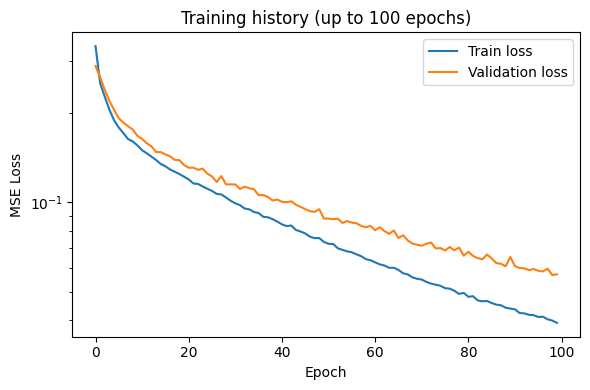


🔍 Evaluating model after 100 epochs...
Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.003158  0.056193  0.021401  0.942226

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000407   0.000296   0.985910
Linear Velocity   0.000028   0.005288   0.003869   0.944587
         Angles   0.000009   0.003061   0.002263   0.980839
  Angular Rates   0.012593   0.112220   0.079175   0.857568
📊 Logged metrics: Epoch 100 | MSE = 3.157688e-03, R2 = 0.942226

🟢 Training up to 200 / 1000 epochs...

Epoch 1/100
74/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0392
Epoch 1: val_loss improved from None to 0.05790, saving model to checkpoints/best_model_until_200.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0579 - learning_rate: 0.0010
Epoch 2/100
76/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395
Epoch 2: val_loss improved fro

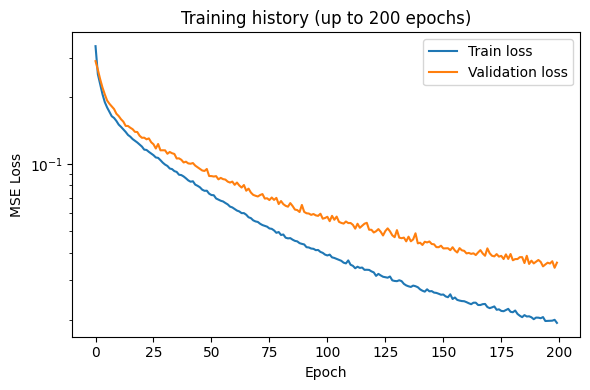


🔍 Evaluating model after 200 epochs...
Loaded model from: checkpoints\model_epoch_200.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.001822  0.042683  0.016246  0.962589

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000378   0.000273   0.988130
Linear Velocity   0.000020   0.004459   0.003215   0.962520
         Angles   0.000007   0.002677   0.001980   0.984913
  Angular Rates   0.007260   0.085207   0.059514   0.914792
📊 Logged metrics: Epoch 200 | MSE = 1.821860e-03, R2 = 0.962589

🟢 Training up to 300 / 1000 epochs...

Epoch 1/100
67/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211
Epoch 1: val_loss improved from None to 0.03478, saving model to checkpoints/best_model_until_300.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/100
74/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0197
Epoch 2: val_loss did not impr

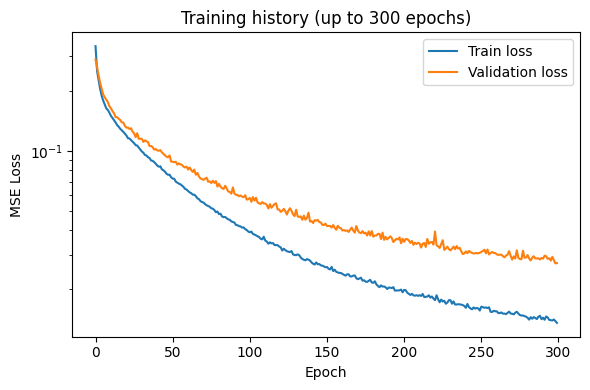


🔍 Evaluating model after 300 epochs...
Loaded model from: checkpoints\model_epoch_300.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.001314  0.036247  0.01359  0.972753

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000346   0.000249   0.990240
Linear Velocity   0.000016   0.004004   0.002861   0.971300
         Angles   0.000006   0.002482   0.001821   0.987350
  Angular Rates   0.005233   0.072340   0.049431   0.942122
📊 Logged metrics: Epoch 300 | MSE = 1.313853e-03, R2 = 0.972753

🟢 Training up to 400 / 1000 epochs...

Epoch 1/100
74/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137
Epoch 1: val_loss improved from None to 0.02813, saving model to checkpoints/best_model_until_400.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 2/100
79/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139
Epoch 2: val_loss improved from 

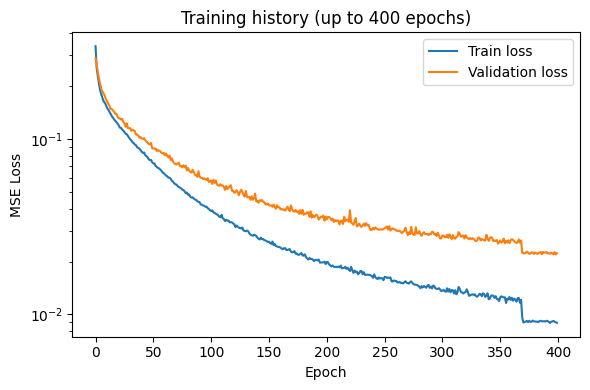


🔍 Evaluating model after 400 epochs...
Loaded model from: checkpoints\model_epoch_400.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.001073  0.032751  0.012061  0.977718

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000319   0.000230   0.991742
Linear Velocity   0.000013   0.003621   0.002551   0.976145
         Angles   0.000005   0.002227   0.001631   0.989803
  Angular Rates   0.004272   0.065363   0.043832   0.953181
📊 Logged metrics: Epoch 400 | MSE = 1.072636e-03, R2 = 0.977718

🟢 Training up to 500 / 1000 epochs...

Epoch 1/100
77/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092
Epoch 1: val_loss improved from None to 0.02199, saving model to checkpoints/best_model_until_500.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0220 - learning_rate: 5.0000e-04
Epoch 2/100
72/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090
Epoch 2: val_loss did not 

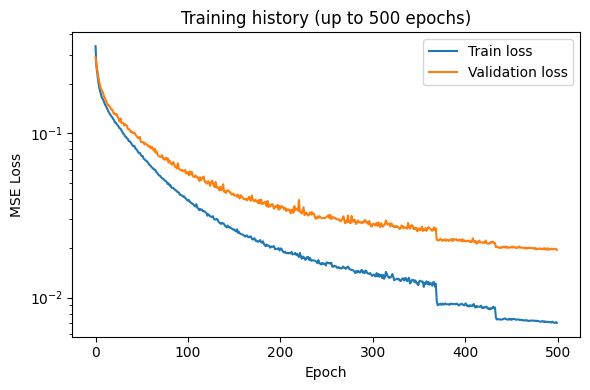


🔍 Evaluating model after 500 epochs...
Loaded model from: checkpoints\model_epoch_500.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.000907  0.030124  0.01091  0.980603

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000301   0.000216   0.992592
Linear Velocity   0.000012   0.003435   0.002402   0.978673
         Angles   0.000004   0.002085   0.001522   0.990970
  Angular Rates   0.003614   0.060113   0.039502   0.960177
📊 Logged metrics: Epoch 500 | MSE = 9.074432e-04, R2 = 0.980603

🟢 Training up to 600 / 1000 epochs...

Epoch 1/100
67/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 1: val_loss improved from None to 0.01972, saving model to checkpoints/best_model_until_600.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0197 - learning_rate: 2.5000e-04
Epoch 2/100
78/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 2: val_loss improved f

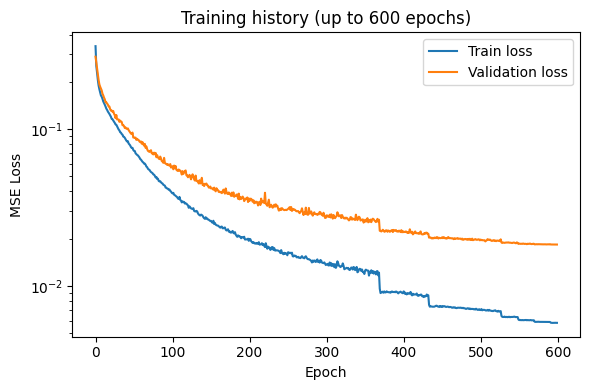


🔍 Evaluating model after 600 epochs...
Loaded model from: checkpoints\model_epoch_600.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.00085  0.029155  0.010399  0.981891

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000291   0.000209   0.993128
Linear Velocity   0.000011   0.003336   0.002335   0.980025
         Angles   0.000004   0.002018   0.001472   0.991495
  Angular Rates   0.003385   0.058180   0.037580   0.962916
📊 Logged metrics: Epoch 600 | MSE = 8.500371e-04, R2 = 0.981891

🟢 Training up to 700 / 1000 epochs...

Epoch 1/100
62/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 1: val_loss improved from None to 0.01836, saving model to checkpoints/best_model_until_700.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0184 - learning_rate: 1.5625e-05
Epoch 2/100
70/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058
Epoch 2: val_loss improved f

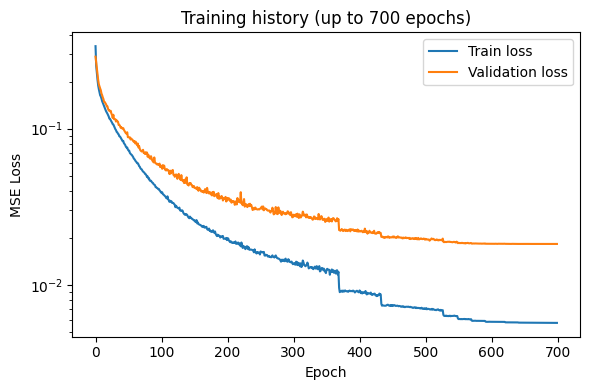


🔍 Evaluating model after 700 epochs...
Loaded model from: checkpoints\model_epoch_700.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.000844  0.029052  0.01036  0.981974

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000290   0.000209   0.993167
Linear Velocity   0.000011   0.003331   0.002331   0.980080
         Angles   0.000004   0.002012   0.001468   0.991532
  Angular Rates   0.003361   0.057973   0.037433   0.963115
📊 Logged metrics: Epoch 700 | MSE = 8.440329e-04, R2 = 0.981974

🟢 Training up to 800 / 1000 epochs...

Epoch 1/100
63/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 1: val_loss improved from None to 0.01829, saving model to checkpoints/best_model_until_800.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0183 - learning_rate: 1.0000e-06
Epoch 2/100
72/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057
Epoch 2: val_loss improved f

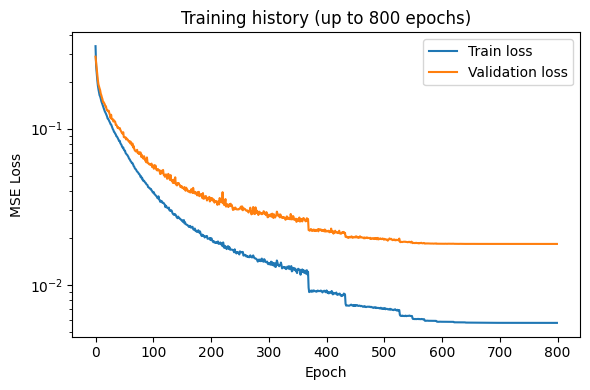


🔍 Evaluating model after 800 epochs...
Loaded model from: checkpoints\model_epoch_800.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.000844  0.029047  0.010355  0.981983

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000290   0.000209   0.993172
Linear Velocity   0.000011   0.003330   0.002330   0.980087
         Angles   0.000004   0.002012   0.001468   0.991536
  Angular Rates   0.003360   0.057963   0.037414   0.963135
📊 Logged metrics: Epoch 800 | MSE = 8.437293e-04, R2 = 0.981983

🟢 Training up to 900 / 1000 epochs...

Epoch 1/100
63/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 1: val_loss improved from None to 0.01829, saving model to checkpoints/best_model_until_900.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0183 - learning_rate: 1.0000e-06
Epoch 2/100
75/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056
Epoch 2: val_loss did not 

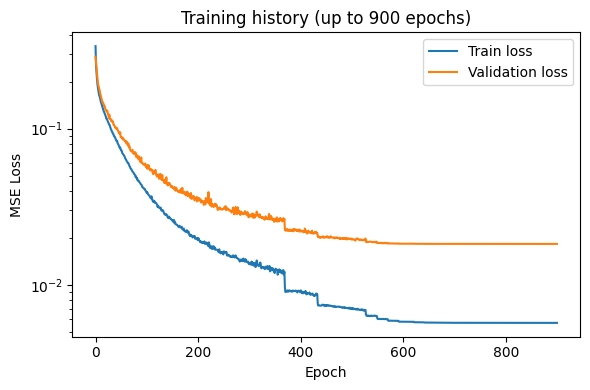


🔍 Evaluating model after 900 epochs...
Loaded model from: checkpoints\model_epoch_900.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.000844  0.029047  0.010355  0.981989

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000290   0.000209   0.993176
Linear Velocity   0.000011   0.003329   0.002330   0.980099
         Angles   0.000004   0.002011   0.001467   0.991542
  Angular Rates   0.003360   0.057964   0.037413   0.963142
📊 Logged metrics: Epoch 900 | MSE = 8.437497e-04, R2 = 0.981989

🟢 Training up to 1000 / 1000 epochs...

Epoch 1/100
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 1: val_loss improved from None to 0.01828, saving model to checkpoints/best_model_until_1000.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0183 - learning_rate: 1.0000e-06
Epoch 2/100
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 2: val_loss did no

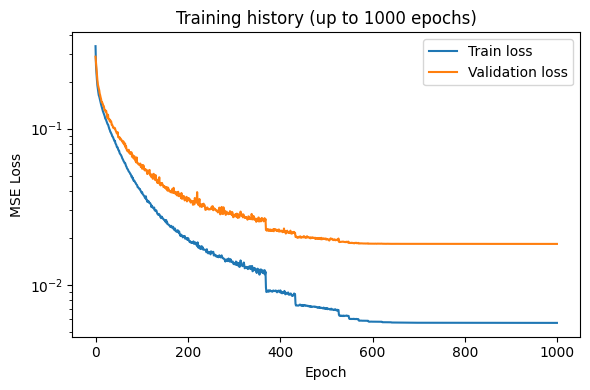


🔍 Evaluating model after 1000 epochs...
Loaded model from: checkpoints\model_epoch_1000.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.000844  0.029048  0.010353  0.981993

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000290   0.000208   0.993179
Linear Velocity   0.000011   0.003329   0.002329   0.980106
         Angles   0.000004   0.002011   0.001467   0.991547
  Angular Rates   0.003360   0.057966   0.037407   0.963142
📊 Logged metrics: Epoch 1000 | MSE = 8.438129e-04, R2 = 0.981993

💾 All experiment parameters and results saved to:
checkpoints\1_all_shuffled.json

📈 Performance summary:
   epochs                          model_path       MSE        R2
0     100   checkpoints\model_epoch_100.keras  0.003158  0.942226
1     200   checkpoints\model_epoch_200.keras  0.001822  0.962589
2     300   checkpoints\model_epoch_300.keras  0.001314  0.972753
3     400   checkpoints\model

In [23]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import joblib
import pandas as pd

# --- Configuration ---
total_epochs = 1000
eval_interval = 100    # evaluate every 100 epochs
batch_size = 128
save_dir = "checkpoints"

os.makedirs(save_dir, exist_ok=True)

# --- Global experiment configuration dictionary ---
experiment_params = {
    "dataset_split" : "All sets shuffled",
    "randdom_seed" : random_seed ,
    "model_name": "MLP",
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "total_epochs": total_epochs,
    "eval_interval": eval_interval,
    "data_file": file_path,
    "model_summary" : layer_sizes,
    "results": []  # will be filled dynamically
    
}

# --- Callbacks ---
def make_callbacks(current_epoch):
    """Create callbacks for the current training chunk."""
    return [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f"{save_dir}/best_model_until_{current_epoch}.keras",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

# --- Save scalers once ---
joblib.dump(sc_in, f"{save_dir}/sc_in.joblib")
joblib.dump(sc_out, f"{save_dir}/sc_out.joblib")

# --- Initialize training record ---
history_all = {'loss': [], 'val_loss': []}

# --- Training and evaluation loop ---
for current_epoch in range(eval_interval, total_epochs + 1, eval_interval):
    print(f"\n🟢 Training up to {current_epoch} / {total_epochs} epochs...\n")

    # Train for eval_interval epochs (continues from current weights)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=eval_interval,
        batch_size=batch_size,
        verbose=1,
        callbacks=make_callbacks(current_epoch),
        shuffle=True
    )

    # --- Update training history ---
    history_all['loss'].extend(history.history['loss'])
    history_all['val_loss'].extend(history.history['val_loss'])

    # --- Save model manually every eval_interval ---
    model_save_path = os.path.join(save_dir, f"model_epoch_{current_epoch}.keras")
    model.save(model_save_path)
    print(f"💾 Model saved at {model_save_path}")

    # --- Best epoch so far ---
    best_epoch = np.argmin(history_all['val_loss']) + 1
    best_val_loss = np.min(history_all['val_loss'])
    print(f"\n🏆 Best epoch so far: {best_epoch} with val_loss = {best_val_loss:.6f}\n")

    # --- Plot training history ---
    plt.figure(figsize=(6, 4))
    plt.plot(history_all['loss'], label='Train loss')
    plt.plot(history_all['val_loss'], label='Validation loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'Training history (up to {current_epoch} epochs)')
    plt.tight_layout()
    plt.show()

    # --- Evaluate model ---
    print(f"\n🔍 Evaluating model after {current_epoch} epochs...")
    results = test_keras_model_grouped(
        model_path=model_save_path,   # evaluate the just-saved model
        X_test=X_test,
        Y_test=Y_test,
        sc_out=sc_out,
        plot_dim=0
    )

    # --- Extract metrics ---
    mse = float(results["overall"]["MSE"])
    r2 = float(results["overall"]["R2"])

    experiment_params["results"].append({
        "epochs": current_epoch,
        "model_path": model_save_path,
        "MSE": mse,
        "R2": r2
    })

    print(f"📊 Logged metrics: Epoch {current_epoch} | MSE = {mse:.6e}, R2 = {r2:.6f}")

# --- Save the entire experiment dictionary as JSON ---
json_path = os.path.join(save_dir, "1_all_shuffled.json")
with open(json_path, "w") as f:
    json.dump(experiment_params, f, indent=4)

print(f"\n💾 All experiment parameters and results saved to:\n{json_path}")

# --- Optional: show quick summary ---
df_results = pd.DataFrame(experiment_params["results"])
print("\n📈 Performance summary:")
print(df_results)


## Training performance
We can observe that our model conserves a very good capability of abstraction while on the other hand is very performative to learn

Loaded model from: checkpoints\model_epoch_600.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.00085  0.029155  0.010399  0.981891

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000291   0.000209   0.993128
Linear Velocity   0.000011   0.003336   0.002335   0.980025
         Angles   0.000004   0.002018   0.001472   0.991495
  Angular Rates   0.003385   0.058180   0.037580   0.962916


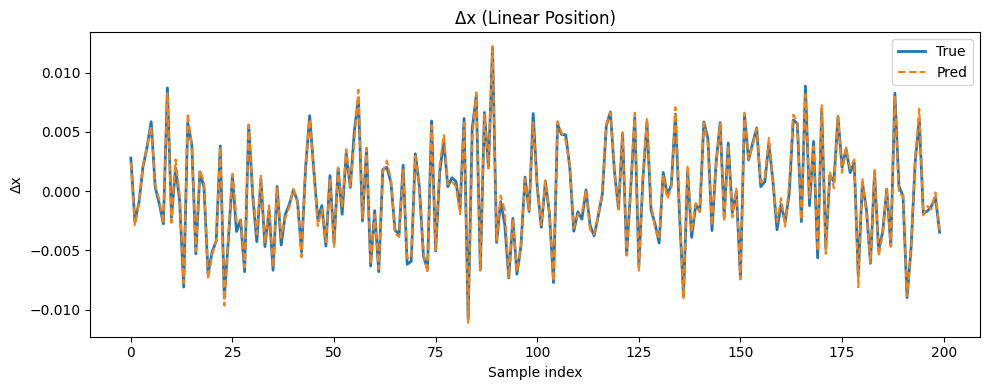

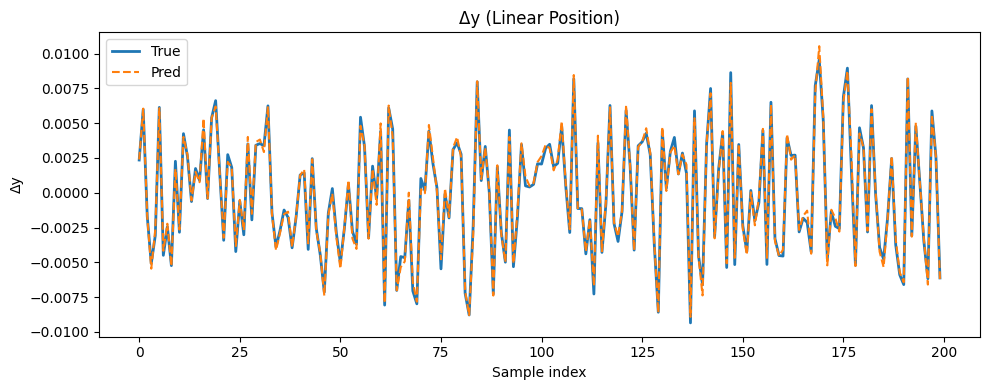

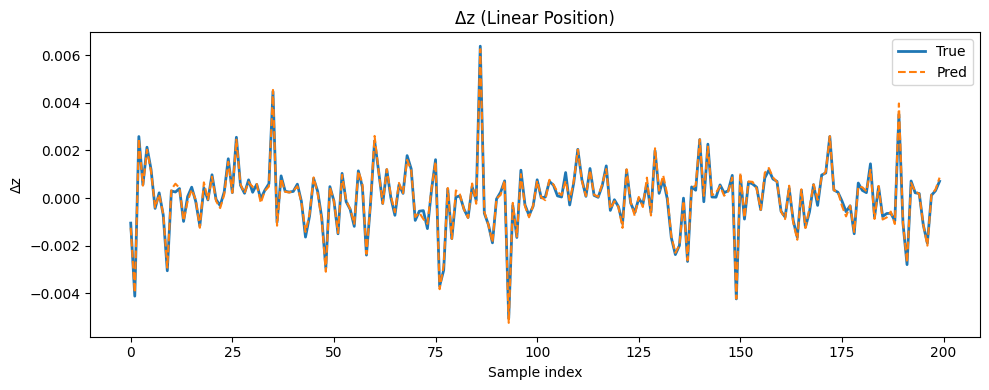

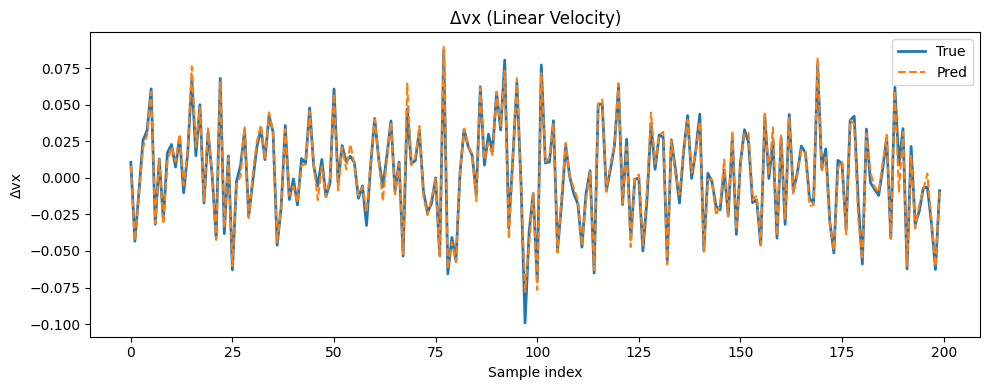

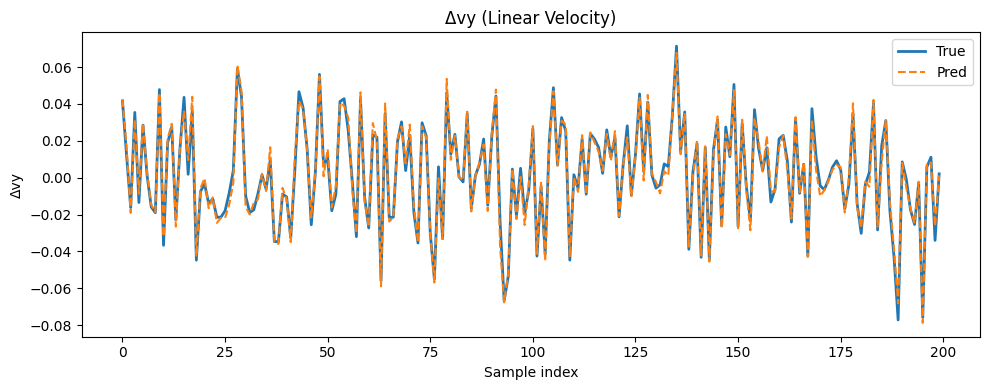

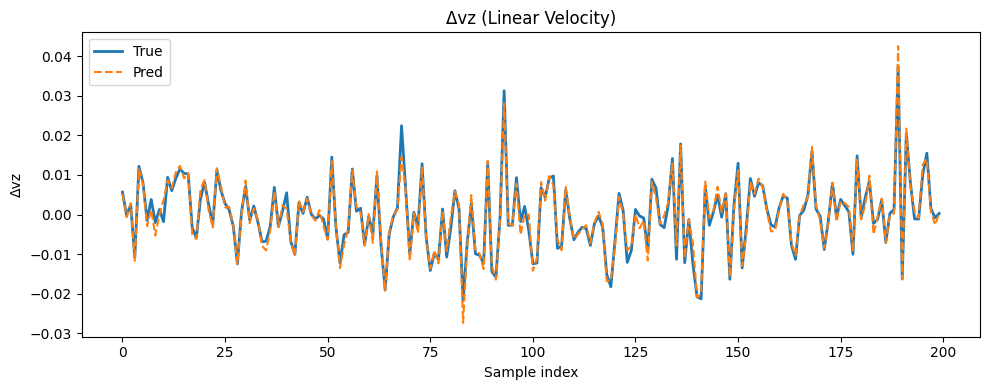

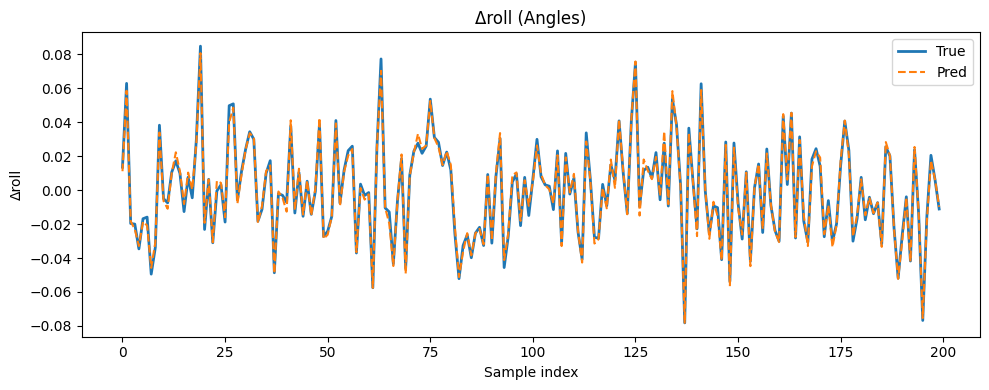

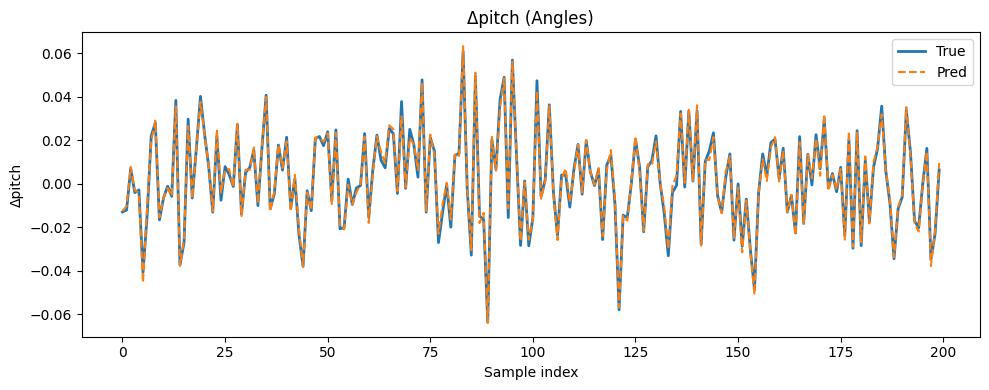

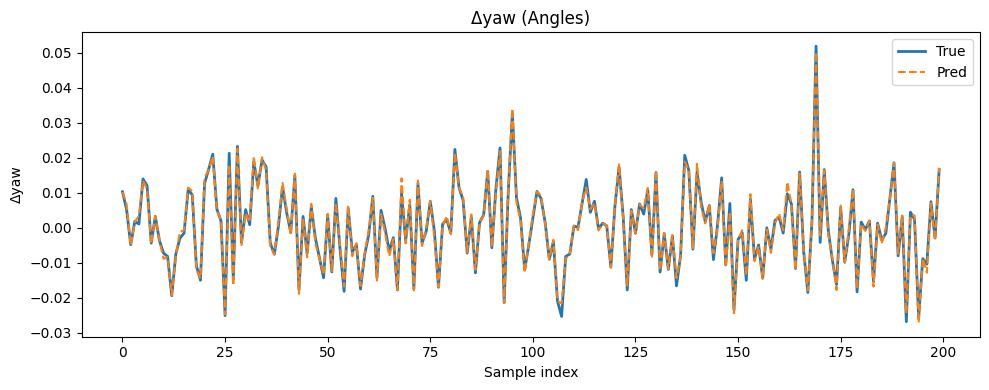

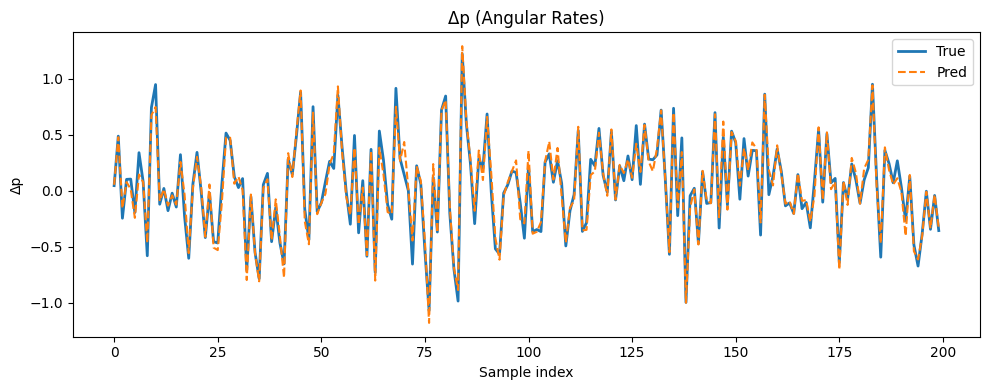

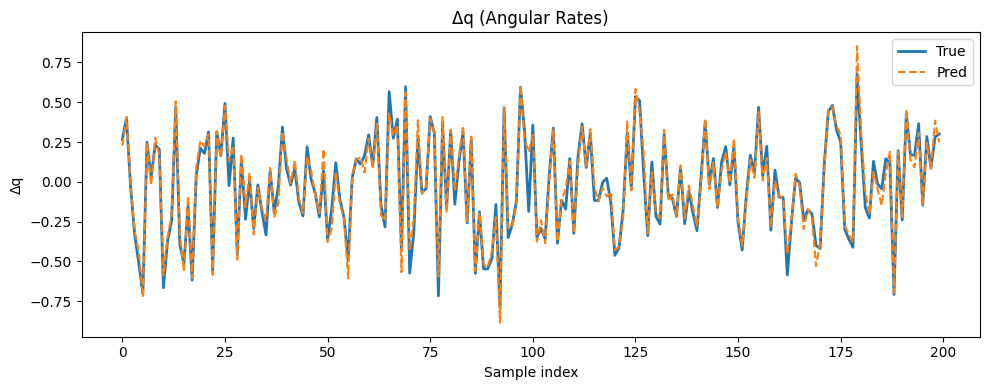

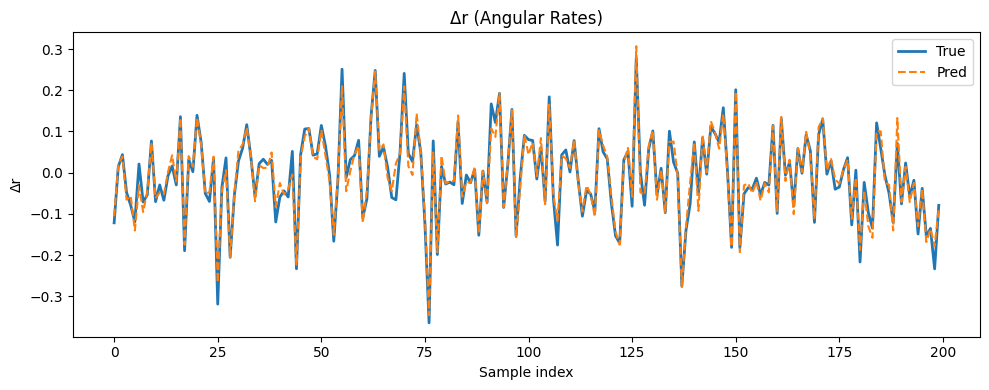

In [24]:
# plotting the 3 best models

# results1 = test_keras_model_grouped(
#     model_path="checkpoints\model_epoch_400.keras",
#     X_test=X_test,
#     Y_test=Y_test,
#     sc_out=sc_out,
#     plot_dim=12   # number of output dimensions to plot
# )

# results2 = test_keras_model_grouped(
#     model_path="checkpoints\model_epoch_500.keras",
#     X_test=X_test,
#     Y_test=Y_test,
#     sc_out=sc_out,
#     plot_dim=12   # number of output dimensions to plot
# )

results3 = test_keras_model_grouped(
    model_path="checkpoints\model_epoch_600.keras",
    X_test=X_test,
    Y_test=Y_test,
    sc_out=sc_out,
    plot_dim=12   # number of output dimensions to plot
)

## Training performance
We have no data left for evaluating a rollout since the test set is composed by shuffled data. Selecting random indices for the training, validation and test set made the net very performative (almost 100%) at understanding the evolution deltaX of the system's dynamics, but makes it impossible to evaluate an open loop rollout on an ordered test set.